### Imports e Configurações

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf

from datetime import datetime, timedelta, timezone

from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import kstest_normal,het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss

from scipy.stats import probplot, moment, shapiro, jarque_bera

In [4]:
seed = 2022 

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
img_dir = os.path.join('..', 'img')

### Funções Uteis

In [7]:
# Calcular a volatilidade realizada diaria
def realized_volatility_daily(series_log_return):
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    # return np.sqrt(np.sum(series_log_return**2))
# Calcular a volatilidade realizada diaria
def realized_volatility(series_log_return):
    n = len(series_log_return)
    # return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    return np.sqrt(np.sum(series_log_return**2))

def transform_volatility_to_scaler(scaler, tf_series):
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output


In [8]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))  
     
def MAPE(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred) 

In [9]:
def get_resid_garch(model):
    gm_resid = model.resid
    gm_std = model.conditional_volatility
    return gm_resid / gm_std

def pvalue_ljungbox(values):
    return acorr_ljungbox(values, lags=[10]).lb_pvalue.iloc[0]

def pvalue_het_arch(values):
    return het_arch(values)[1]

def pvalue_shapiro(values):
    return shapiro(values)[1]

In [10]:
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE', "MAPE"])
analysis_df = pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [
        model_name, 
        RMSPE(y_true, y_pred), 
         RMSE(y_true, y_pred), 
         MAPE(y_true, y_pred)
    ]
    return perf_df

def log_garch(model, model_name, isNormal = True):
    analysis_df.loc[len(analysis_df.index)] = [
        model_name, 
        model.aic,
        model.bic,
        pvalue_ljungbox(get_resid_garch(model)),
        pvalue_ljungbox(get_resid_garch(model)**2),
        pvalue_het_arch(get_resid_garch(model)),
        pvalue_shapiro(get_resid_garch(model)) if isNormal else 0
    ]
    return analysis_df

def reset_log_garch():
    analysis_df = pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

In [11]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [12]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [13]:
### GARCH FUNTIONS
def scale_tf_cond_vol(model_result):
    cond_vol = model_result.conditional_volatility
    scaler = StandardScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))
    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

### Analise Exploratória 

In [213]:
start = datetime(2015, 1, 1)
end = datetime(2022, 10, 1)

In [214]:
ticker_name = "^BVSP"
ticker = yf.Ticker(ticker_name)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

In [244]:
## Interpolar Time series (Preencher valores nulos)
date_range = pd.date_range(
    start=start, 
    end=end,
    freq='D'
  )
data = df.reset_index()
data['Date'] = data['Date'].astype('datetime64[ns]')
data_aux = pd.DataFrame({'Date': date_range })
data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
data.interpolate(method='linear', inplace=True)
data = df.reset_index()
data['Date'] =data['Date'].apply(lambda x: x.replace(tzinfo=None))
data_aux = pd.DataFrame({'Date': date_range })
data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
data.interpolate(method='linear', inplace=True)


In [246]:
data = data.dropna()

In [247]:
df = data

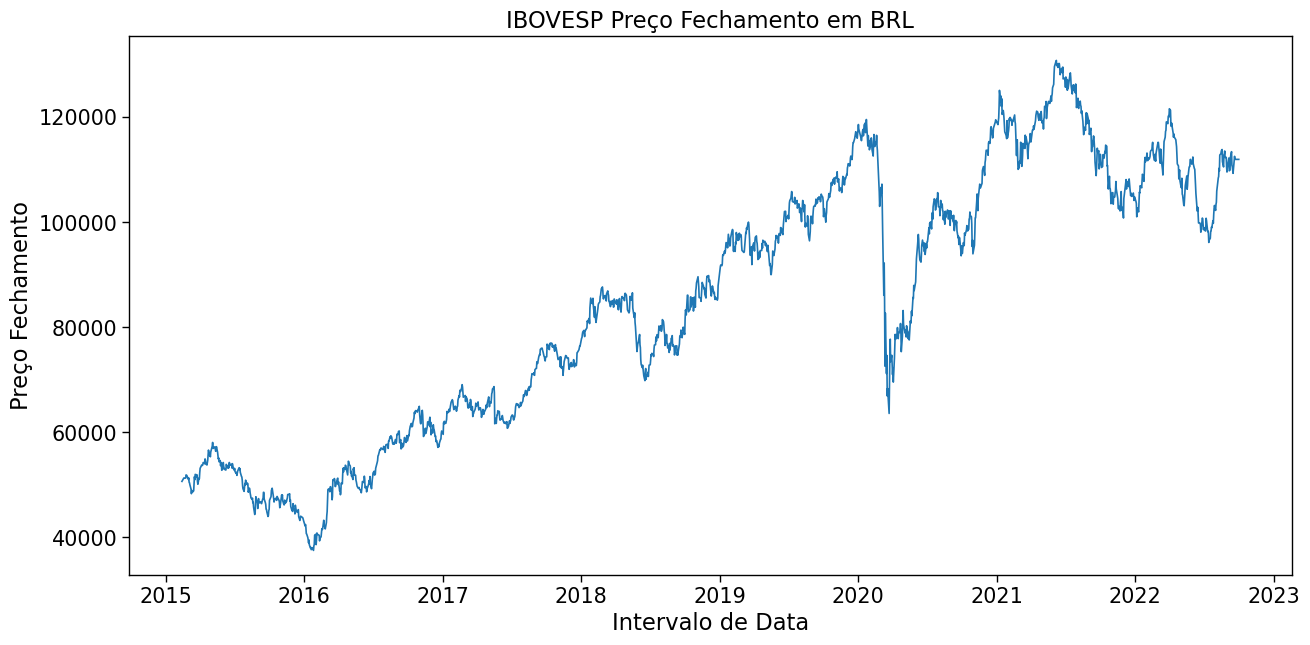

In [248]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df.Close)
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')
plt.savefig(os.path.join(img_dir, 'ibovesp-preco.jpg'), dpi=300, bbox_inches='tight');

In [249]:
df['returns'] = 100 * df['Close'].pct_change().dropna()

LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

In [250]:
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))

In [251]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,
2015-02-13,49546.0,50726.0,49476.0,50636.0,3888100.0,0.0,0.0,NaN,NaN,0.016535,0.014370
2015-02-14,49764.6,50954.4,49708.6,50764.8,3698620.0,0.0,0.0,0.254364,0.002540,0.016479,0.014356
2015-02-15,49983.2,51182.8,49941.2,50893.6,3509140.0,0.0,0.0,0.253719,0.002534,0.016422,0.014343


In [252]:
df.dropna(inplace=True)

In [253]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,
2015-02-14,49764.6,50954.4,49708.6,50764.8,3698620.0,0.0,0.0,0.254364,0.002540,0.016479,0.014356
2015-02-15,49983.2,51182.8,49941.2,50893.6,3509140.0,0.0,0.0,0.253719,0.002534,0.016422,0.014343
2015-02-16,50201.8,51411.2,50173.8,51022.4,3319660.0,0.0,0.0,0.253077,0.002528,0.016365,0.014329


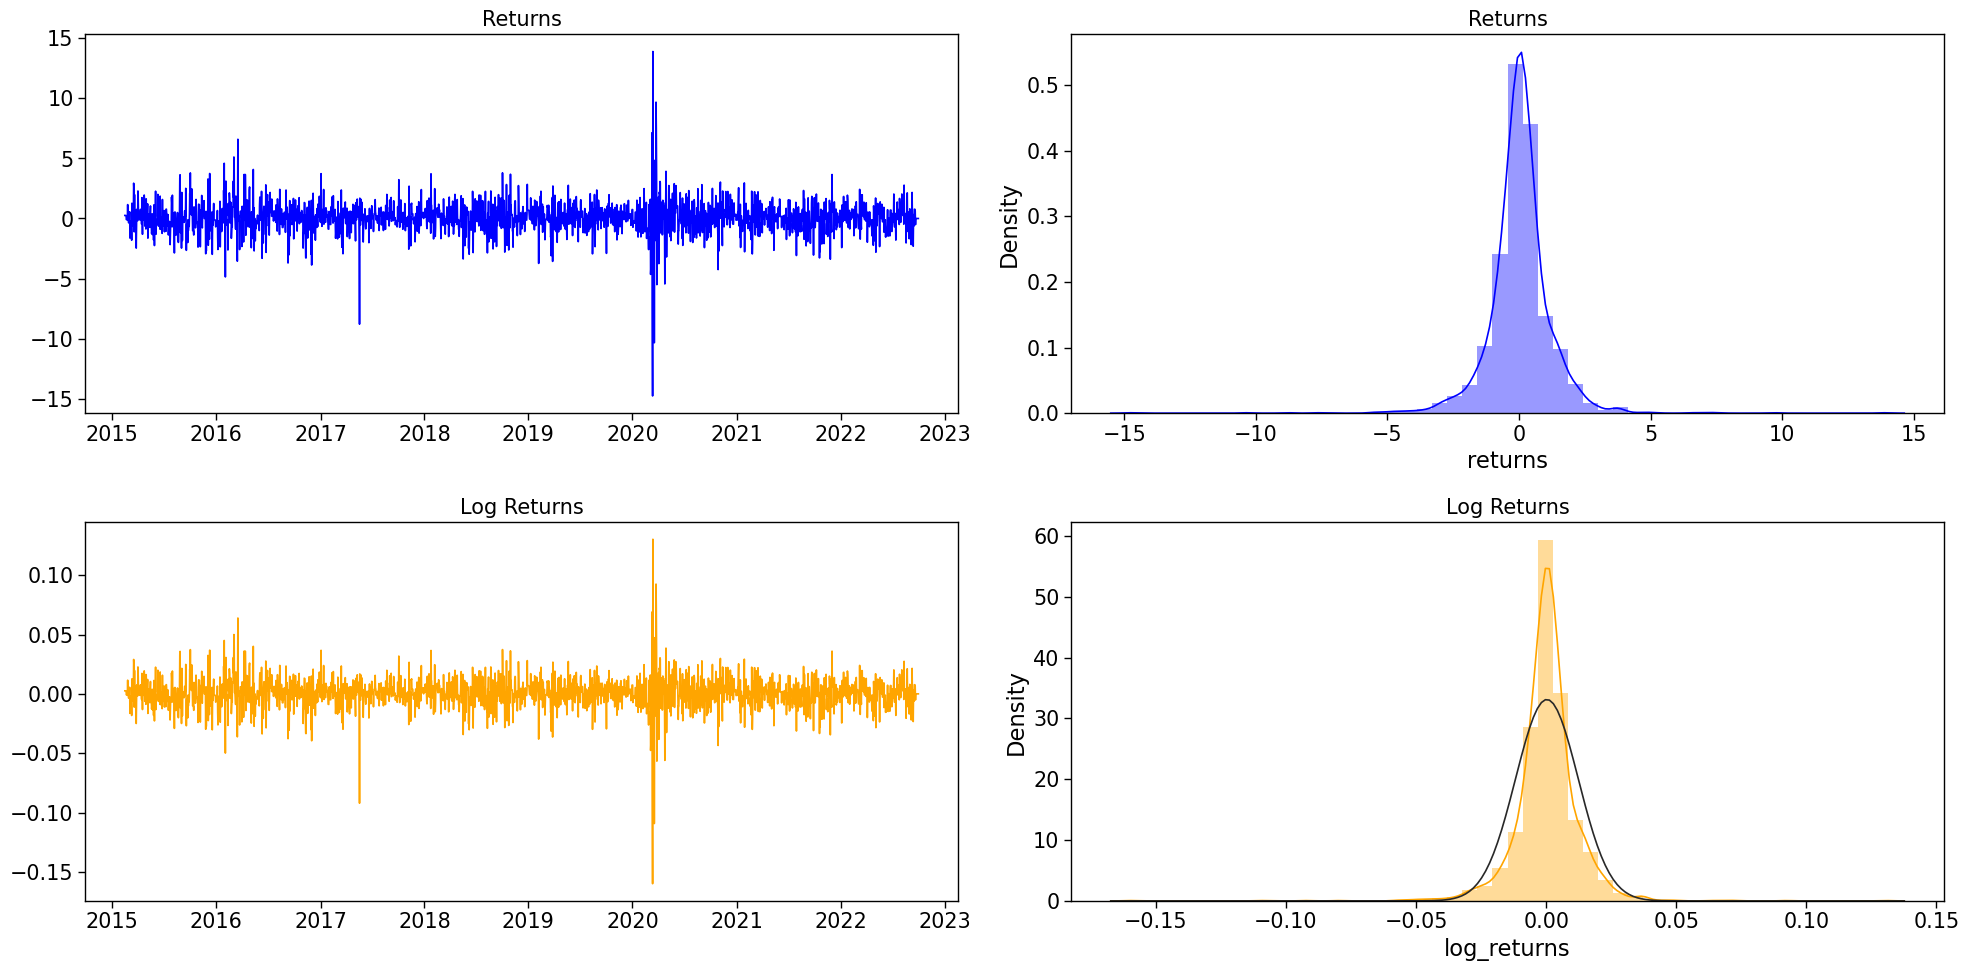

In [254]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df['returns'], color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df['returns'],  color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df['log_returns'], color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df['log_returns'], norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'returns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

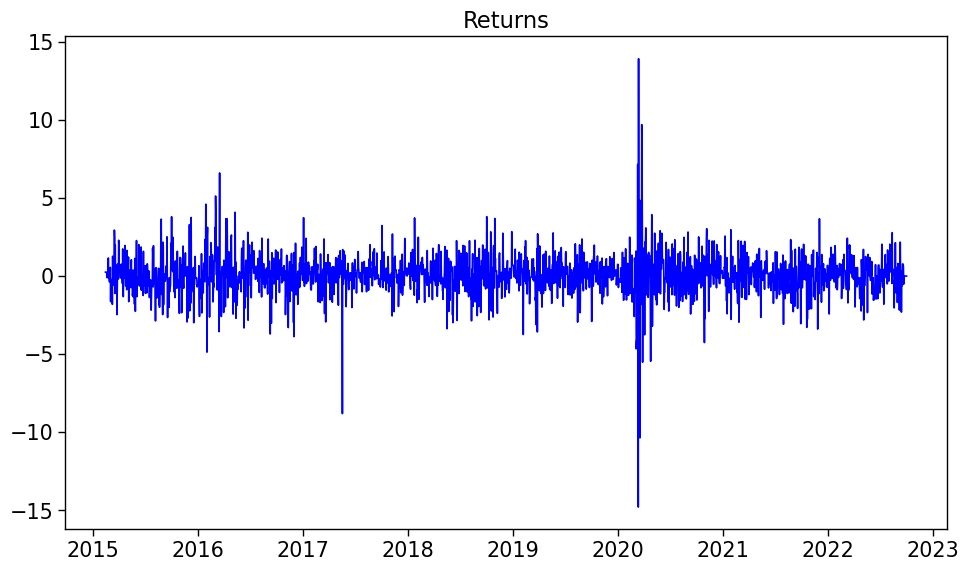

In [255]:
plt.figure(figsize=(10, 6))
plt.plot(df['returns'], color='blue')
plt.title('Returns')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'simple-return.png'), dpi=300, bbox_inches='tight')
fig.show();

In [256]:
df['returns'].describe()

count    2787.000000
mean        0.035709
std         1.201190
min       -14.779679
25%        -0.446165
50%         0.029612
75%         0.526280
max        13.908215
Name: returns, dtype: float64

In [257]:
stats.skew(df['returns'])

-0.34749715108520496

In [258]:
stats.kurtosis(df['returns'])

21.909680636674555

In [259]:
df['log_returns'].describe()

count    2787.000000
mean        0.000285
std         0.012053
min        -0.159930
25%        -0.004472
50%         0.000296
75%         0.005249
max         0.130223
Name: log_returns, dtype: float64

In [260]:
stats.skew(df['log_returns'])

-0.7878901554350691

In [261]:
stats.kurtosis(df['log_returns'])


23.57279662197921

In [262]:
shapiro(df['returns'])

ShapiroResult(statistic=0.8571721315383911, pvalue=9.80908925027372e-45)

#### **Returns/Log Returns Estacionariedade**

In [263]:
adfuller_results = adfuller(df['log_returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.250018995110864
p-value: 1.7212775125919258e-20
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [264]:
# RETURNS
adfuller_results = adfuller(df['returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.334808447926
p-value: 1.090311563661304e-20
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [265]:
kpss_results = kpss(df['returns']);
print(kpss_results)

(0.05715634844318695, 0.1, 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\gabriel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Para o nível de significancia com alpha igual a 0.05, o `p-value` de ambos, tanto o Retorno quanto do Log Retorno são menores que o alpha, logo tem-se evidencia suficiente para rejeitar a Hipotese nula.

### Verificar Autocorrelação e Autocorrelação Parcial

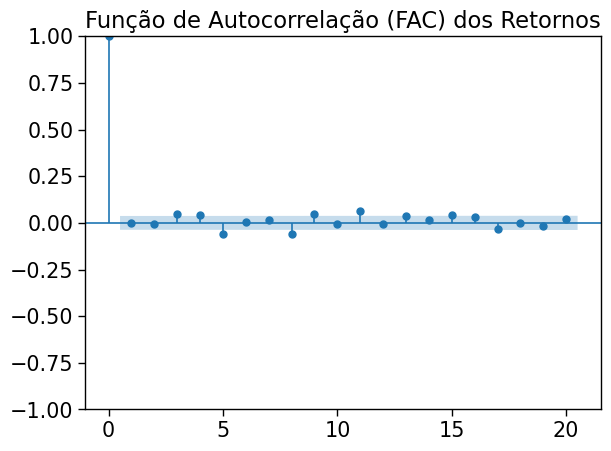

In [266]:
plot_acf(df['returns'], lags=20,  title="Função de Autocorrelação (FAC) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return.jpg'), dpi=300, bbox_inches='tight')

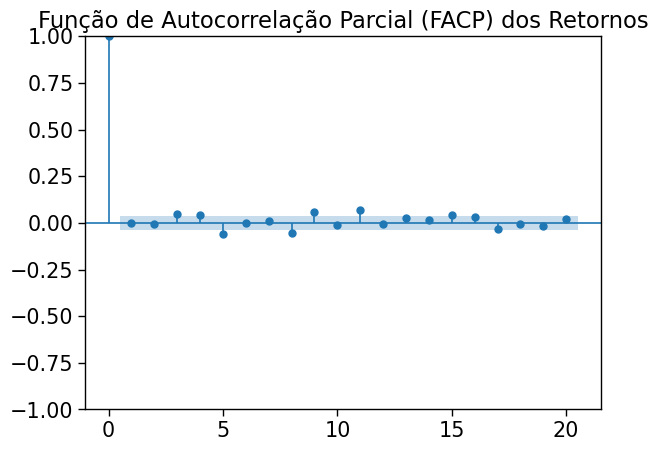

In [267]:
plot_pacf(df['returns'], lags=20, title="Função de Autocorrelação Parcial (FACP) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return.jpg'), dpi=300, bbox_inches='tight')

In [268]:
acorr_ljungbox(df['returns'], lags=10)

,lb_stat,lb_pvalue
1,0.000157,0.989998
2,0.151079,0.927243
3,6.697287,0.082198
4,12.109836,0.016553
5,22.140999,0.000492
6,22.173381,0.001126
7,22.929583,0.001753
8,32.030088,0.000092
9,39.070870,0.000011
10,39.165149,0.000024


In [269]:
INTERVAL_WINDOW = 30
n_future = 7

df['vol_current'] = df['log_returns'].rolling(window=INTERVAL_WINDOW)\
  .apply(realized_volatility_daily)

df['vol_future'] = df['log_returns']\
    .shift(-n_future)\
    .rolling(window=INTERVAL_WINDOW)\
      .apply(realized_volatility_daily)


In [270]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,
2015-02-14,49764.6,50954.4,49708.6,50764.8,3698620.0,0.0,0.0,0.254364,0.002540,NaN,NaN
2015-02-15,49983.2,51182.8,49941.2,50893.6,3509140.0,0.0,0.0,0.253719,0.002534,NaN,NaN
2015-02-16,50201.8,51411.2,50173.8,51022.4,3319660.0,0.0,0.0,0.253077,0.002528,NaN,NaN
2015-02-17,50420.4,51639.6,50406.4,51151.2,3130180.0,0.0,0.0,0.252438,0.002521,NaN,NaN
2015-02-18,50639.0,51868.0,50639.0,51280.0,2940700.0,0.0,0.0,0.251802,0.002515,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,112517.0,113294.0,111380.0,111936.0,14726800.0,0.0,0.0,0.000000,0.000000,0.008943,NaN
2022-09-28,112517.0,113294.0,111380.0,111936.0,14726800.0,0.0,0.0,0.000000,0.000000,0.008943,NaN
2022-09-29,112517.0,113294.0,111380.0,111936.0,14726800.0,0.0,0.0,0.000000,0.000000,0.008368,NaN


In [271]:
df.dropna(inplace=True)

Text(0, 0.5, 'Preço Fechamento')

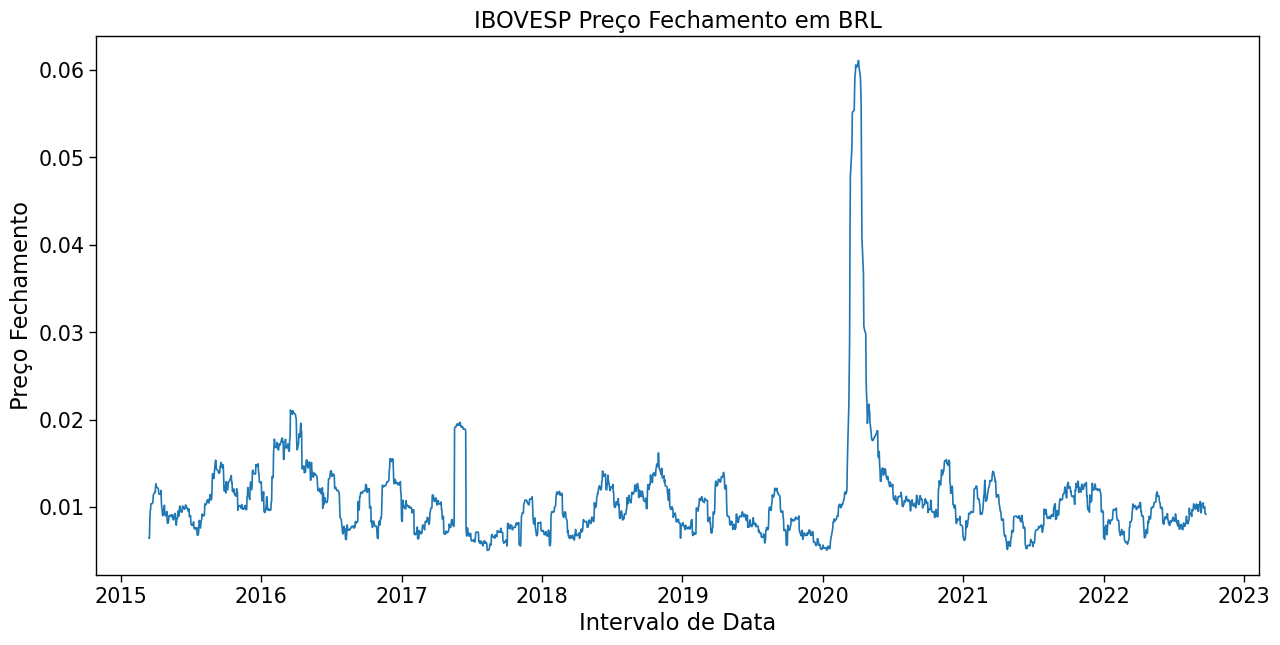

In [272]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df['vol_current'])
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')

### Treino - Teste - Validação 

O dataset será dividido em:
- Os 30 itens finais serão utilizados para teste final.
- 1 ano inteiro para validação e ajustes do modelo
- E o restante para treinamento

In [273]:
test_size = 30
val_size = 365

# INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# PARA DIVIDIR O DATASET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [274]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2015-03-15 00:00:00 	to: 2021-08-25 00:00:00 	2356 days
Validation 	From: 2021-08-26 00:00:00 	to: 2022-08-25 00:00:00 	365 days
Test 		From: 2022-08-26 00:00:00 	to: 2022-09-24 00:00:00 	30 days


In [275]:
y_train = df['vol_future'][train_idx]
y_val = df['vol_future'][val_idx]
y_test = df['vol_future'][test_idx]

In [276]:
x_train = df['vol_current'][train_idx]
x_val = df['vol_current'][val_idx]
x_test = df['vol_current'][test_idx]

In [277]:
r_train = df['returns'][train_idx]
r_val = df['returns'][val_idx]
r_test = df['returns'][test_idx]

In [278]:
lr_train = df['log_returns'][train_idx]
lr_val = df['log_returns'][val_idx]
lr_test = df['log_returns'][test_idx]

### Normalizar os dados

In [279]:
scaler_vol = StandardScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [280]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

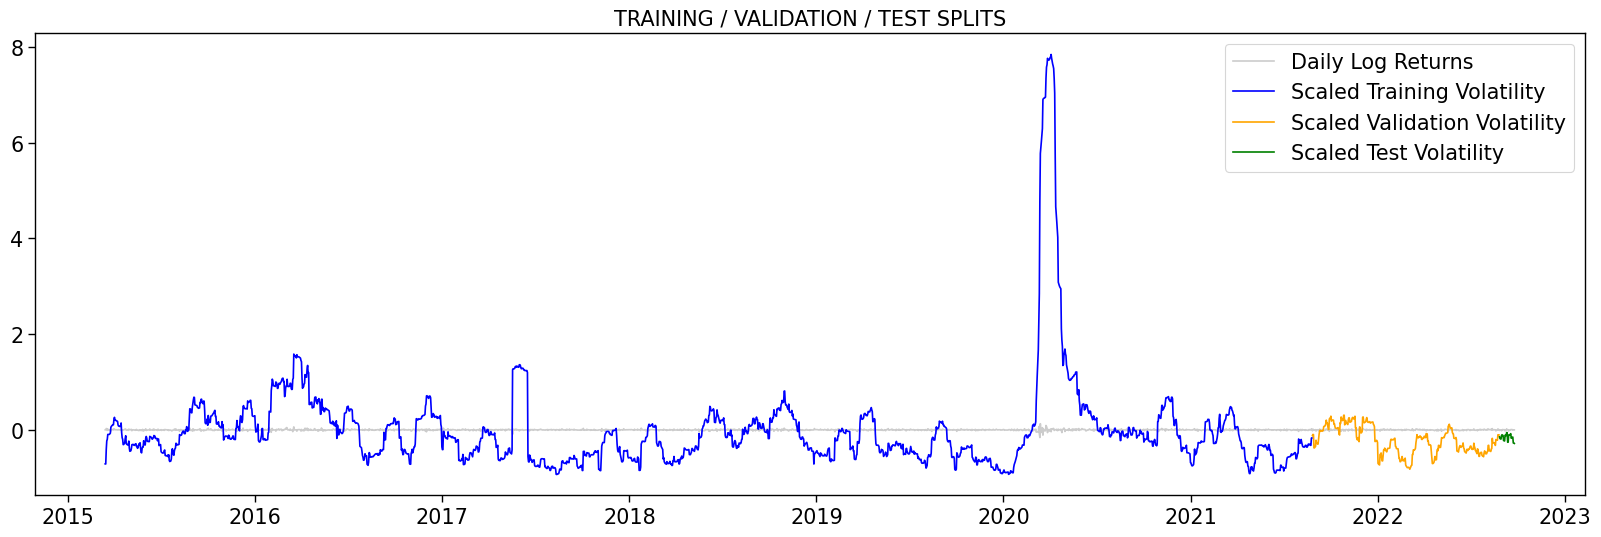

In [281]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(x_train_scaled, color='blue', label='Scaled Training Volatility')
plt.plot(x_val_scaled, color='orange', label='Scaled Validation Volatility')
plt.plot(x_test_scaled, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join(img_dir, 'train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

### GARCH MODELS

some Util links
- https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html
- https://users.metu.edu.tr/home402/ozancan/wwwhome/ARCHGARCHTutorial.html
- https://bibliotecadigital.fgv.br/dspace/bitstream/handle/10438/10014/TD%20313%20-%20CEQEF%2003%20-%20Marcos%20Vinicio%20Wink%20Junior%20e%20%20Pedro%20Valls.pdf?sequence=1
- https://repositorio.ufc.br/bitstream/riufc/39729/1/2018_tcc_wlalves.pdf
- file:///C:/Users/Gabriel/Downloads/paulo%20thomaz.pdf

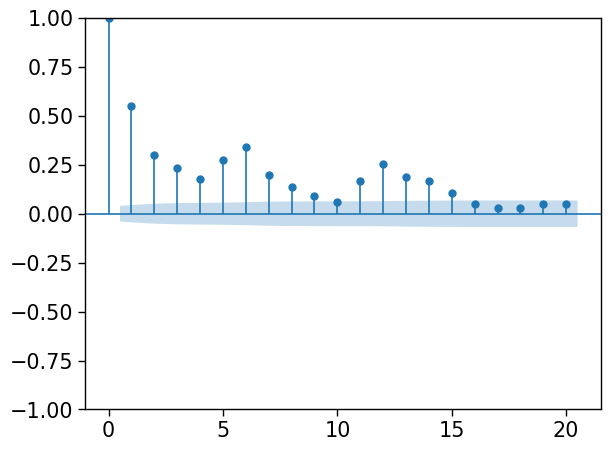

In [282]:
plot_acf(r_train**2,lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return-squared.jpg'), dpi=300, bbox_inches='tight')

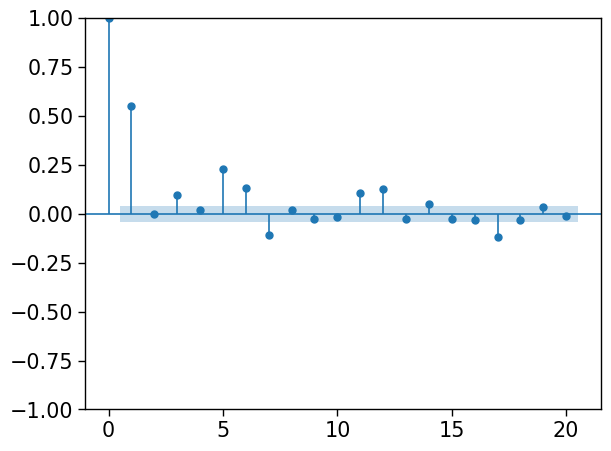

In [283]:
plot_pacf(r_train**2, lags=20, title="")
        #   title='Função de Autocorrelação Parcial (FACP) do quadrado dos Retornos\n(Treinamento)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return-squared.jpg'), dpi=300, bbox_inches='tight')

Verifica-se pelo quadrado dos retornos que o modelo ARCH é adaquado

In [284]:
pvalue_ljungbox(r_train)

5.149541906862157e-06

Como há autocorrelação significativa nos retornos da serie, uma vez que p < 0.005, logo, é necessário aplicação de um modelo ARMA, antes do modelo GARCH

In [285]:
from pmdarima.arima import auto_arima

In [286]:
arma = auto_arima(
  r_train,
  d=0,
  max_q=12,
  max_p=12,
  trace=True,
  seasonal=False,
  error_action='ignore',
  suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7712.648, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7719.692, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7721.586, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7721.583, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7724.768, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7724.605, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7712.554, Time=0.85 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7718.503, Time=0.32 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=7702.667, Time=1.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=7711.012, Time=0.44 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=7685.967, Time=2.01 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=7707.629, Time=0.85 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=7684.550, Time=2.32 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=7709.620, Time=0.27 sec
 ARIMA(7,0,2)(0,0,0)[0]          

In [287]:
resid_arma = arma.resid()

In [288]:
acorr_ljungbox(resid_arma)

,lb_stat,lb_pvalue
1,0.000242,0.987583
2,0.000520,0.999740
3,0.001035,0.999991
4,0.002064,0.999999
5,0.005676,1.000000
6,0.163363,0.999915
7,0.877838,0.996566
8,2.199852,0.974264
9,2.254997,0.986764
10,5.486139,0.856433


In [289]:
het_arch(resid_arma, nlags=10 )

(786.2240977180406,
 1.88751691212529e-162,
 117.69852742857438,
 1.09278843142311e-198)

Logo o modelo ARMA (2,2) é possível remover autocorrelação significativa da serie de retornos.

In [290]:
hetarch_results =   (resid_arma)

print(f'Lagrange statistic: {hetarch_results[0]}')
print(f'p-value: {hetarch_results[1]}')

Lagrange statistic: 0.12599712977342578
p-value: 0.12671389321591933


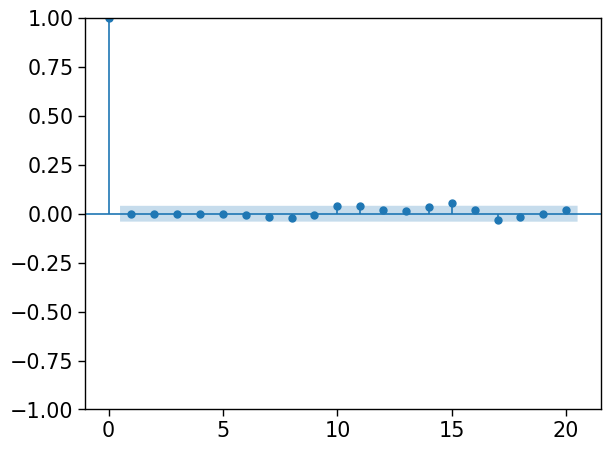

In [291]:
plot_acf(resid_arma,  lags=20, title="");
        #   title='Função de Autocorrelação (FAC) dos residuos\n(ARMA(2,2)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-arma.png'), dpi=300, bbox_inches='tight')

Pelo teste ARCH, p-value indica que existe presença de heteroscedasticidade significativa nos resíduos do modelo ARMA

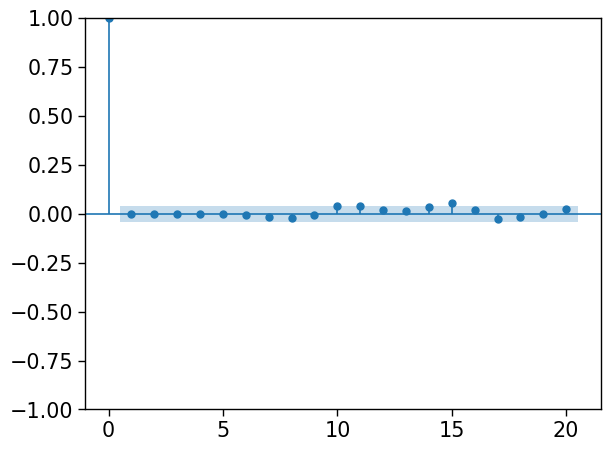

In [292]:
plot_pacf(resid_arma, lags=20,title="");
        #   title='Função de Autocorrelação Parcial (FACP) dos residuos\n(ARMA(2,2))');

plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-arma.png'), dpi=300, bbox_inches='tight')

evidenciam que a autocorrelação nos resíduos foi eliminada, com apenas um pico de autocorrelação na primeira defasagem

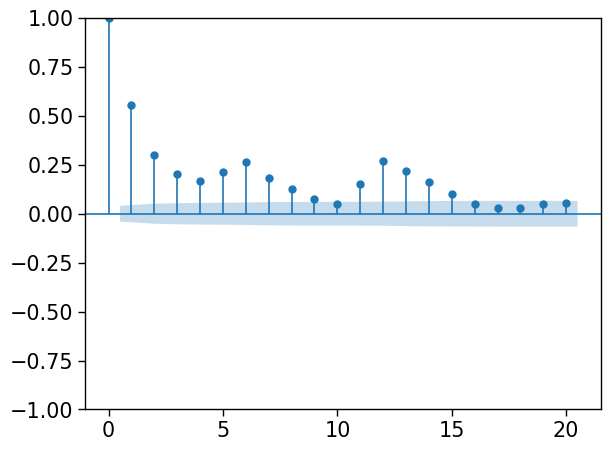

In [293]:
plot_acf(resid_arma**2,  lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos residuos\n(ARMA(2,2)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-arma-squared.png'), dpi=300, bbox_inches='tight')

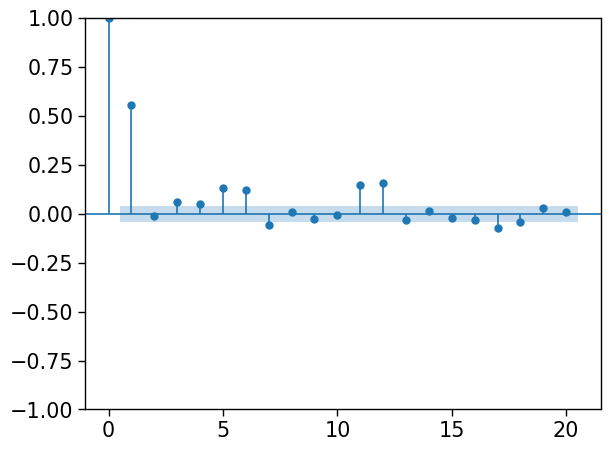

In [294]:
plot_pacf(resid_arma**2, lags=20, title="");
        #   title='Função de Autocorrelação Parcial (FACP) do quadrado dos residuos\n(ARMA(2,2))');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-arma-squared.png'), dpi=300, bbox_inches='tight')

Os resíduos ao quadrado, nota-se que existe presença de heteroscedasticidade condicional, sendo que esta permanece até defasagens elevadas, o que indica alta persistência na volatilidade.

### GARCH

In [295]:
from arch import arch_model

In [296]:
gm_22 = arch_model(r_train, p=2, q=2)
result_22 = gm_22.fit(disp='off')
gm_11 = arch_model(r_train, p=1, q=1)
result_11 = gm_11.fit(disp='off')
gm_21 = arch_model(r_train, p=2, q=1)
result_21 = gm_21.fit(disp='off')
gm_12 = arch_model(r_train, p=1, q=2)
result_12 = gm_12.fit(disp='off')

gm_10 = arch_model(r_train, p=1, q=0)
result_10 = gm_10.fit(disp='off')

In [297]:
result_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3478.76
Distribution:                  Normal   AIC:                           6965.52
Method:            Maximum Likelihood   BIC:                           6988.58
                                        No. Observations:                 2356
Date:                Sat, Feb 18 2023   Df Residuals:                     2355
Time:                        21:37:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0730  2.197e-02      3.323  8.901e-04 [2.994e-02,  0.116]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0689  4.006e-02      1.720  8.546e-02 [-9.620e-03,  0.147]
alpha[1]       0.0833  2.881e-02      2.891  3.837e-03  [2.683e-02,  0.140]
beta[1]        0.8614  5.588e-02     15.416  1.278e-53    [  0.752,  0.971]
===========================================================================

Covariance estimator: robust
"""

In [298]:
log_garch(result_11, "GARCH (1,1) - Normal")

,Model,AIC,BIC,LB,LB(r²),ARCH,SW
0,"GARCH (1,1) - Normal",5462.671292,5483.995533,0.667495,0.943101,0.945088,1.944160e-13
1,"GARCH (1,1) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
2,"GARCH (2,2) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
3,"GJR-GARCH (1,1) - Normal",5447.566840,5474.222141,0.753289,0.957178,0.956365,1.202898e-12
4,"TARCH (1,1) - Normal",5441.607278,5468.262579,0.614699,0.966097,0.959508,2.332019e-12
5,"GARCH (1,1) - Normal",5408.088457,5429.359962,0.663741,0.939942,0.942302,2.680011e-13
6,"GARCH (1,1) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
7,"GARCH (2,2) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
8,"GJR-GARCH (1,1) - Normal",5393.473412,5420.062793,0.747572,0.964336,0.963866,1.632323e-12
9,"TARCH (1,1) - Normal",5387.279513,5413.868894,0.607239,0.971092,0.965364,3.342438e-12


Utilizando nivel de significande de 0.05, nenhum dos coefieficientes para os modelos (1,2), (2,1), (2,2) parecem ser estatisticamente significante, já que o os seus p-values `P > |t|` são todos maiores que 0.05. diferente do GARCH (1,1)

É possivel verificar que que pelo test `Shapiro Wilk (SW)`, `p-value` é menor que 0.05, portanto é rejeita-se a hipotese nula e assim, temos evidencia suficiente para dizer que não segue uma distribuição normal, o que é comum para series financeiras, porém o modelo garch permite setar a distribuição como T Student , 

In [299]:
gm_student_11 = arch_model(r_train, p=1, q=1, dist="StudentsT")
result_student_11 = gm_student_11.fit(disp='off')
gm_student_22 = arch_model(r_train, p=2, q=2, dist="StudentsT")
result_student_22 = gm_student_22.fit(disp='off')
gm_student_12 = arch_model(r_train, p=1, q=2, dist="StudentsT")
result_student_12 = gm_student_12.fit(disp='off')
gm_student_21 = arch_model(r_train, p=2, q=1, dist="StudentsT")
result_student_21 = gm_student_21.fit(disp='off')

In [300]:
result_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3290.51
Distribution:      Standardized Student's t   AIC:                           6591.02
Method:                  Maximum Likelihood   BIC:                           6619.85
                                              No. Observations:                 2356
Date:                      Sat, Feb 18 2023   Df Residuals:                     2355
Time:                              21:37:14   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0607  1.600e-02      3.794  1.482e-04 [2.934e-02,9.205e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0593  3.031e-02      1.957  5.031e-02 [-8.077e-05,  0.119]
alpha[1]       0.0904  3.256e-02      2.776  5.507e-03  [2.656e-02,  0.154]
beta[1]        0.8973  3.788e-02     23.690 4.531e-124    [  0.823,  0.972]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.8664      0.197     14.552  5.653e-48 [  2.480,  3.252]
========================================================================

Covariance estimator: robust
"""

In [302]:
log_garch(result_student_11, "GARCH (1,1) - Student", False)

,Model,AIC,BIC,LB,LB(r²),ARCH,SW
0,"GARCH (1,1) - Normal",5462.671292,5483.995533,0.667495,0.943101,0.945088,1.944160e-13
1,"GARCH (1,1) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
2,"GARCH (2,2) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
3,"GJR-GARCH (1,1) - Normal",5447.566840,5474.222141,0.753289,0.957178,0.956365,1.202898e-12
4,"TARCH (1,1) - Normal",5441.607278,5468.262579,0.614699,0.966097,0.959508,2.332019e-12
5,"GARCH (1,1) - Normal",5408.088457,5429.359962,0.663741,0.939942,0.942302,2.680011e-13
6,"GARCH (1,1) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
7,"GARCH (2,2) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
8,"GJR-GARCH (1,1) - Normal",5393.473412,5420.062793,0.747572,0.964336,0.963866,1.632323e-12
9,"TARCH (1,1) - Normal",5387.279513,5413.868894,0.607239,0.971092,0.965364,3.342438e-12


In [303]:
scaler_garch_11, scaled_cond_vol_11 = scale_tf_cond_vol(result_11)

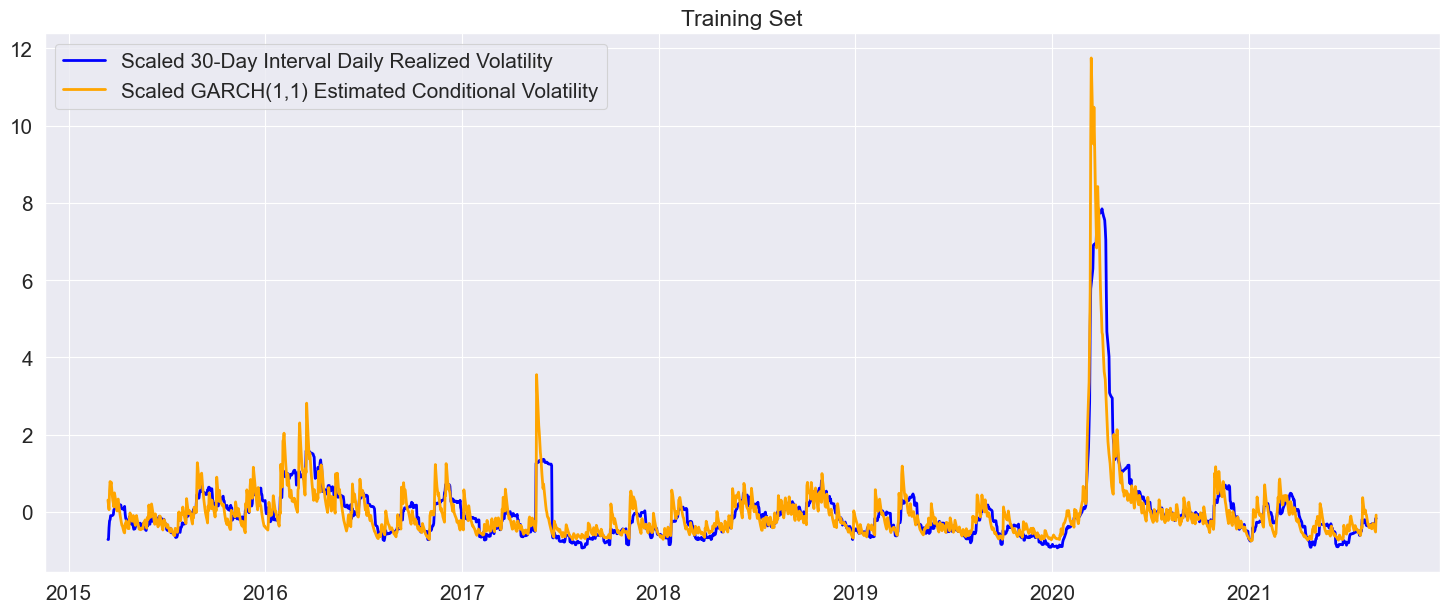

In [304]:
viz_cond_vol(scaled_cond_vol_11, 'GARCH(1,1)')

### Expanding Window Forecasting

Será dada a previsão para os próximo dias futuros `n_future = 14` e assim deve-se reajustar o modelo para cada passo no tempo.


In [305]:
def expading_window_forecast_garch(arch_model):
    size = len(val_idx)
    rolling_forecasts = []
    idx = df.index
    # Set de validação
    for i in range(0, size, 1):
    # Pegar os valores anteriores a esse step
        idx = val_idx[i]
        train = df.returns[:idx]
        # treinar o modelo até esse step
        model = arch_model(train)
        model_fit = model.fit(disp='off')
        # fazer a predição com n_future 
        values = model_fit.forecast(horizon=1, 
                             reindex=False).variance.iloc[0]
        for value in values:
            rolling_forecasts.append(value)
    values_forecast = []
    for i in range(size):
        values_forecast.append(rolling_forecasts[i]**.5)
    return pd.Series(values_forecast, index=val_idx)

In [306]:
gm_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1) )

In [307]:
gm_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_11, gm_11_preds)

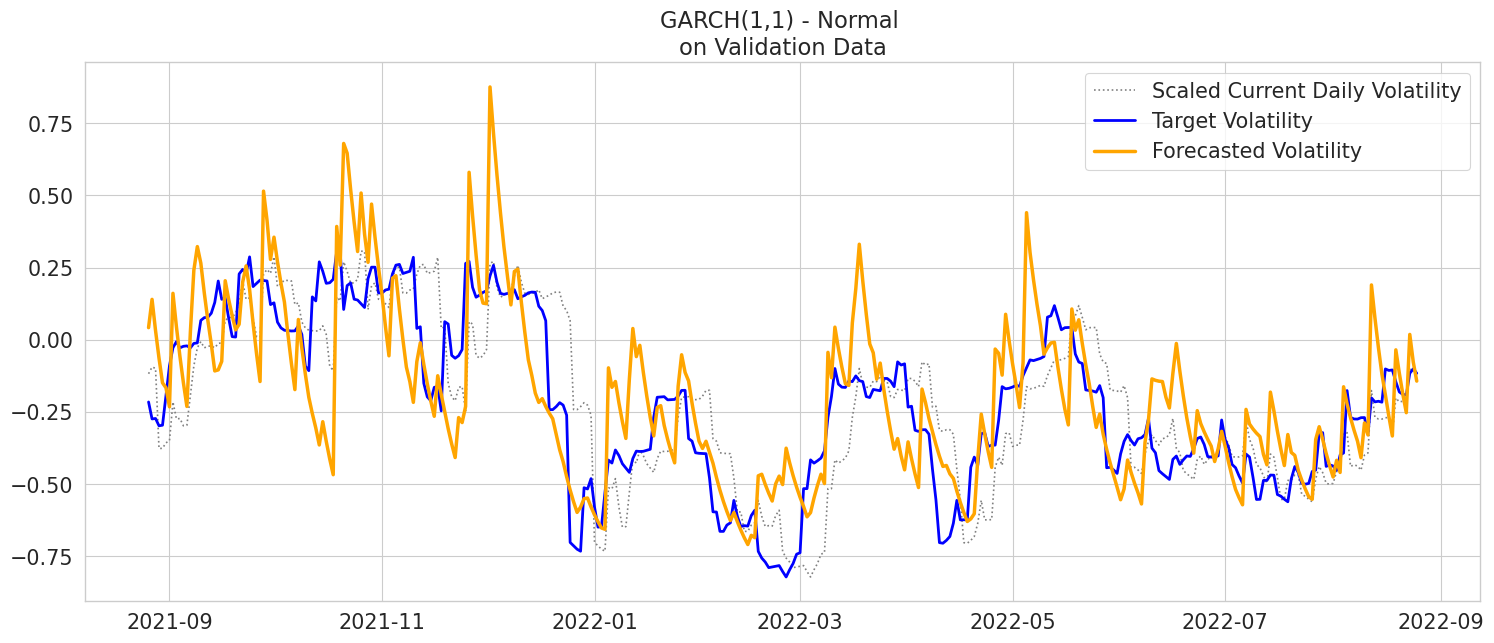

In [308]:
viz_model(y_val_scaled, gm_11_preds_scaled, 'GARCH(1,1) - Normal')

In [309]:
log_perf(y_val_scaled, gm_11_preds_scaled,'GARCH(1,1) - Normal')

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"GARCH(1,1) - Normal",2.804197,0.198950,1.061152
1,"GARCH(1,1) - Student",2.560835,0.183397,0.974900
2,"GARCH(2,2) - Student",2.839917,0.194501,1.066700
3,"GARCH(1,1) - Normal",2.981327,0.183111,1.091091
4,"GARCH(1,1) - Student",2.630303,0.168665,0.980298
5,"GARCH(2,2) - Student",2.845461,0.178480,1.062523
6,"GARCH(1,1) - Normal",2.697622,0.207025,1.183090


In [310]:
gm_student_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1, dist="StudentsT") )
scaler_garch_student_11, scaled_cond_vol_student_11 = scale_tf_cond_vol(result_student_11)
gm_student_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_student_11, gm_student_11_preds)
log_perf(y_val_scaled, gm_student_11_preds_scaled,'GARCH(1,1) - Student')

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"GARCH(1,1) - Normal",2.804197,0.198950,1.061152
1,"GARCH(1,1) - Student",2.560835,0.183397,0.974900
2,"GARCH(2,2) - Student",2.839917,0.194501,1.066700
3,"GARCH(1,1) - Normal",2.981327,0.183111,1.091091
4,"GARCH(1,1) - Student",2.630303,0.168665,0.980298
5,"GARCH(2,2) - Student",2.845461,0.178480,1.062523
6,"GARCH(1,1) - Normal",2.697622,0.207025,1.183090
7,"GARCH(1,1) - Student",2.099552,0.177573,0.965111


### Garch Model with asymmetric shock response

In [176]:
gjr_gm_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH')
result_gjr_gm_11 = gjr_gm_11.fit(disp='off')
gjr_gm_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH')
result_gjr_gm_22 = gjr_gm_22.fit(disp='off')
gjr_gm_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH')
result_gjr_gm_21 = gjr_gm_21.fit(disp='off')
gjr_gm_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH')
result_gjr_gm_12 = gjr_gm_12.fit(disp='off')

In [177]:
result_gjr_gm_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2691.58
Distribution:                  Normal   AIC:                           5395.15
Method:            Maximum Likelihood   BIC:                           5427.06
                                        No. Observations:                 1507
Date:                Sat, Feb 18 2023   Df Residuals:                     1506
Time:                        20:58:13   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0778  3.554e-02      2.188  2.866e-02 [8.110e-03,  0.147]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1439  7.409e-02      1.943  5.203e-02 [-1.266e-03,  0.289]
alpha[1]       0.0249  4.220e-02      0.590      0.555 [-5.783e-02,  0.108]
alpha[2]       0.0187  4.350e-02      0.429      0.668 [-6.659e-02,  0.104]
gamma[1]       0.1189  5.627e-02      2.113  3.456e-02  [8.640e-03,  0.229]
beta[1]        0.8356  6.042e-02     13.830  1.680e-43    [  0.717,  0.954]
===========================================================================

Covariance estimator: robust
"""

In [178]:
log_garch(result_gjr_gm_11, "GJR-GARCH (1,1) - Normal")

,Model,AIC,BIC,LB,LB(r²),ARCH,SW
0,"GARCH (1,1) - Normal",5462.671292,5483.995533,0.667495,0.943101,0.945088,1.944160e-13
1,"GARCH (1,1) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
2,"GARCH (2,2) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
3,"GJR-GARCH (1,1) - Normal",5447.566840,5474.222141,0.753289,0.957178,0.956365,1.202898e-12
4,"TARCH (1,1) - Normal",5441.607278,5468.262579,0.614699,0.966097,0.959508,2.332019e-12
5,"GARCH (1,1) - Normal",5408.088457,5429.359962,0.663741,0.939942,0.942302,2.680011e-13
6,"GARCH (1,1) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
7,"GARCH (2,2) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
8,"GJR-GARCH (1,1) - Normal",5393.473412,5420.062793,0.747572,0.964336,0.963866,1.632323e-12


In [179]:
gjr_gm_student_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_11 = gjr_gm_student_11.fit(disp='off')
gjr_gm_student_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_22 = gjr_gm_student_22.fit(disp='off')
gjr_gm_student_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_21 = gjr_gm_student_21.fit(disp='off')
gjr_gm_student_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_12 = gjr_gm_student_12.fit(disp='off')

### TARCH

In [180]:

np.random.seed(seed)
t_gm_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='normal')
result_t_gm_11 = t_gm_11.fit(disp='off')
t_gm_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='normal')
result_t_gm_22 = t_gm_22.fit(disp='off')
t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='normal')
result_t_gm_21 = t_gm_21.fit(disp='off')
t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='normal')
result_t_gm_12 = t_gm_12.fit(disp='off')

In [181]:
result_t_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -2688.64
Distribution:                  Normal   AIC:                           5387.28
Method:            Maximum Likelihood   BIC:                           5413.87
                                        No. Observations:                 1507
Date:                Sat, Feb 18 2023   Df Residuals:                     1506
Time:                        20:58:13   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0652  3.724e-02      1.750  8.013e-02 [-7.821e-03,  0.138]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0826  3.510e-02      2.353  1.861e-02   [1.381e-02,  0.151]
alpha[1]       0.0448  1.991e-02      2.249  2.451e-02 [5.756e-03,8.382e-02]
gamma[1]       0.1141  3.484e-02      3.275  1.056e-03   [4.582e-02,  0.182]
beta[1]        0.8670  3.843e-02     22.561 1.056e-112     [  0.792,  0.942]
============================================================================

Covariance estimator: robust
"""

In [182]:
log_garch(result_t_gm_11, "TARCH (1,1) - Normal")

,Model,AIC,BIC,LB,LB(r²),ARCH,SW
0,"GARCH (1,1) - Normal",5462.671292,5483.995533,0.667495,0.943101,0.945088,1.944160e-13
1,"GARCH (1,1) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
2,"GARCH (2,2) - Student",5396.784597,5423.439899,0.667553,0.937571,0.940561,0.000000e+00
3,"GJR-GARCH (1,1) - Normal",5447.566840,5474.222141,0.753289,0.957178,0.956365,1.202898e-12
4,"TARCH (1,1) - Normal",5441.607278,5468.262579,0.614699,0.966097,0.959508,2.332019e-12
5,"GARCH (1,1) - Normal",5408.088457,5429.359962,0.663741,0.939942,0.942302,2.680011e-13
6,"GARCH (1,1) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
7,"GARCH (2,2) - Student",5343.533899,5370.123280,0.661321,0.927548,0.931625,0.000000e+00
8,"GJR-GARCH (1,1) - Normal",5393.473412,5420.062793,0.747572,0.964336,0.963866,1.632323e-12
9,"TARCH (1,1) - Normal",5387.279513,5413.868894,0.607239,0.971092,0.965364,3.342438e-12


In [183]:
# t_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, p=1, o=1, q=1, power=1.0) )
# scaler_tarch_11, scaled_tarch_cond_vol_11 = scale_tf_cond_vol(result_student_11)
# t_11_preds_scaled = transform_volatility_to_scaler(scaler_tarch_11, t_11_preds)

In [184]:
e_gm_11 = arch_model(r_train, vol='EGARCH', p=1, o=1, q=1, power=1.0, dist='normal')
result_e_gm_11 = e_gm_11.fit(disp='off')
print(result_e_gm_11.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2689.87
Distribution:                  Normal   AIC:                           5389.73
Method:            Maximum Likelihood   BIC:                           5416.32
                                        No. Observations:                 1507
Date:                Sat, Feb 18 2023   Df Residuals:                     1506
Time:                        20:58:14   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0683  3.674e-02      1.859  6.296e-02 [-3.69

In [185]:

np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -2657.42
Distribution:      Standardized Skew Student's t   AIC:                           5330.84
Method:                       Maximum Likelihood   BIC:                           5373.38
                                                   No. Observations:                 1507
Date:                           Sat, Feb 18 2023   Df Residuals:                     1506
Time:                                   20:58:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [186]:

np.random.seed(seed)

t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0,
                  dist='skewt')
result_gm_21 = t_gm_21.fit(disp='off')
print(result_gm_21.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -2657.00
Distribution:      Standardized Skew Student's t   AIC:                           5330.01
Method:                       Maximum Likelihood   BIC:                           5372.55
                                                   No. Observations:                 1507
Date:                           Sat, Feb 18 2023   Df Residuals:                     1506
Time:                                   20:58:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [187]:

np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=2, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -2656.95
Distribution:      Standardized Skew Student's t   AIC:                           5331.90
Method:                       Maximum Likelihood   BIC:                           5379.76
                                                   No. Observations:                 1507
Date:                           Sat, Feb 18 2023   Df Residuals:                     1506
Time:                                   20:58:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [188]:

np.random.seed(seed)

t_gm_student_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='t')
result_gm_student_11 = t_gm_student_11.fit(disp='off')
print(result_gm_student_11.summary())

                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -2658.23
Distribution:      Standardized Student's t   AIC:                           5328.47
Method:                  Maximum Likelihood   BIC:                           5360.37
                                              No. Observations:                 1507
Date:                      Sat, Feb 18 2023   Df Residuals:                     1506
Time:                              20:58:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### REDES NEURAIS

In [311]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [312]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return tf.convert_to_tensor(dataX), tf.convert_to_tensor(dataY)

In [313]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [314]:
# Forecast RNN
def forecast(model, range_idx, n_past):
    start_idx = range_idx[0] - timedelta(n_past -1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [315]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [316]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [317]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 21
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

In [318]:
snn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 21)                0         
                                                                 
 dense (Dense)               (None, 1)                 22        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [319]:
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

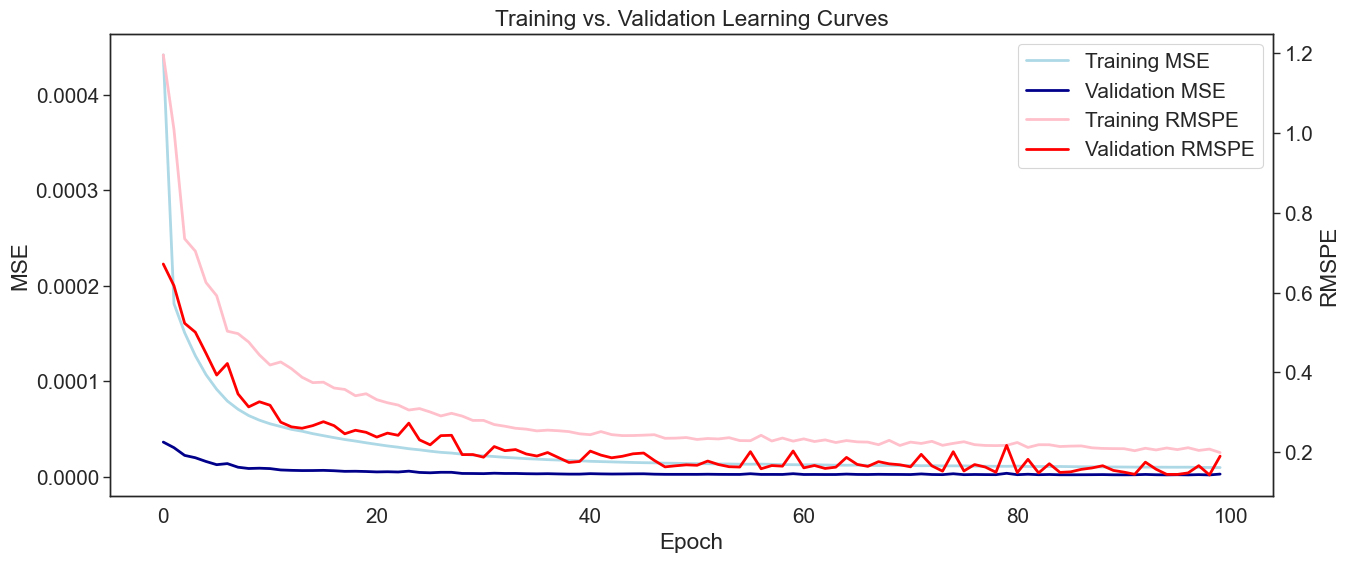

In [320]:
viz_train_val_metrics(snn_1_res)

In [321]:
snn_1_preds = forecast(snn_1, val_idx, n_past=n_past)
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 2ms/step


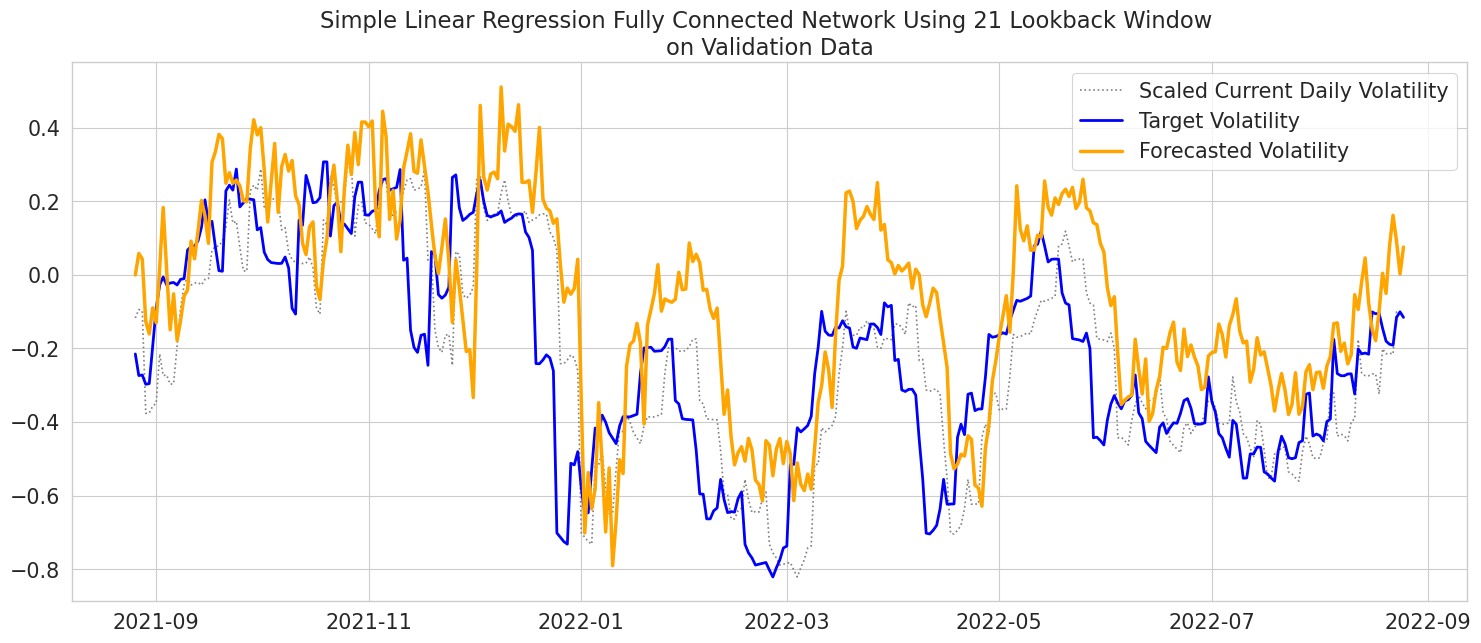

In [322]:
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [323]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"GARCH(1,1) - Normal",2.804197,0.198950,1.061152
1,"GARCH(1,1) - Student",2.560835,0.183397,0.974900
2,"GARCH(2,2) - Student",2.839917,0.194501,1.066700
3,"GARCH(1,1) - Normal",2.981327,0.183111,1.091091
4,"GARCH(1,1) - Student",2.630303,0.168665,0.980298
5,"GARCH(2,2) - Student",2.845461,0.178480,1.062523
6,"GARCH(1,1) - Normal",2.697622,0.207025,1.183090
7,"GARCH(1,1) - Student",2.099552,0.177573,0.965111
8,"Simple LR Fully Connected NN, n_past=21",3.637323,0.269018,1.449894


### LSTM


In [324]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [326]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(200),
    tf.keras.layers.Dropout(0.1),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [327]:
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

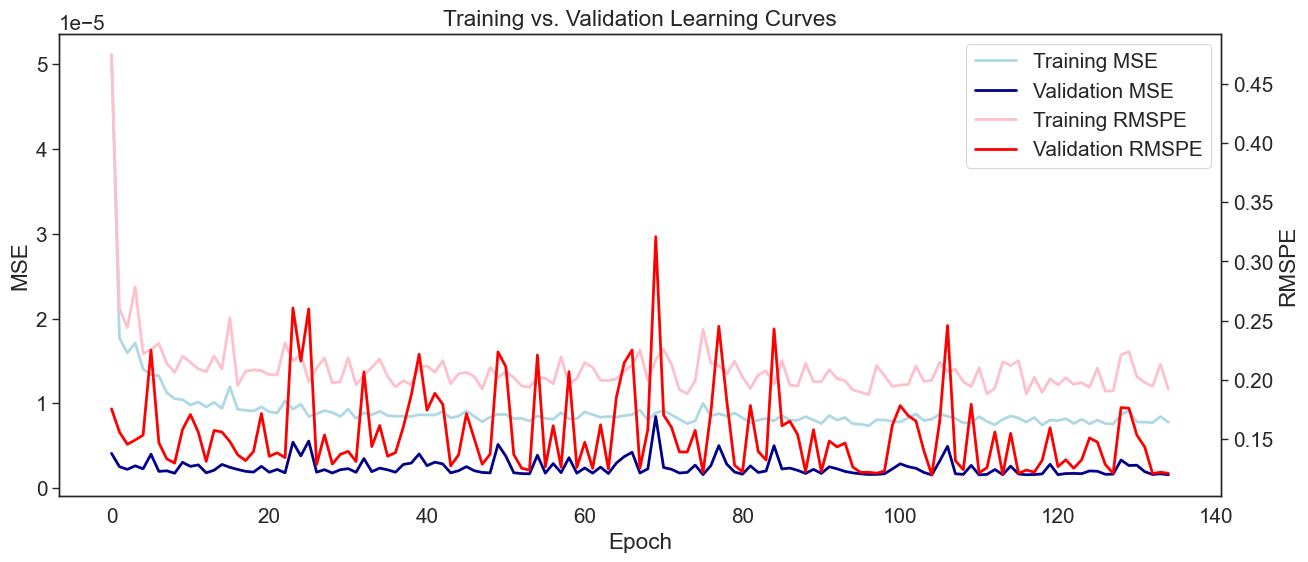

In [328]:
viz_train_val_metrics(lstm_1_res)

In [331]:
lstm_1_preds = forecast(lstm_1, val_idx, n_past=n_past)
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 1s 6ms/step


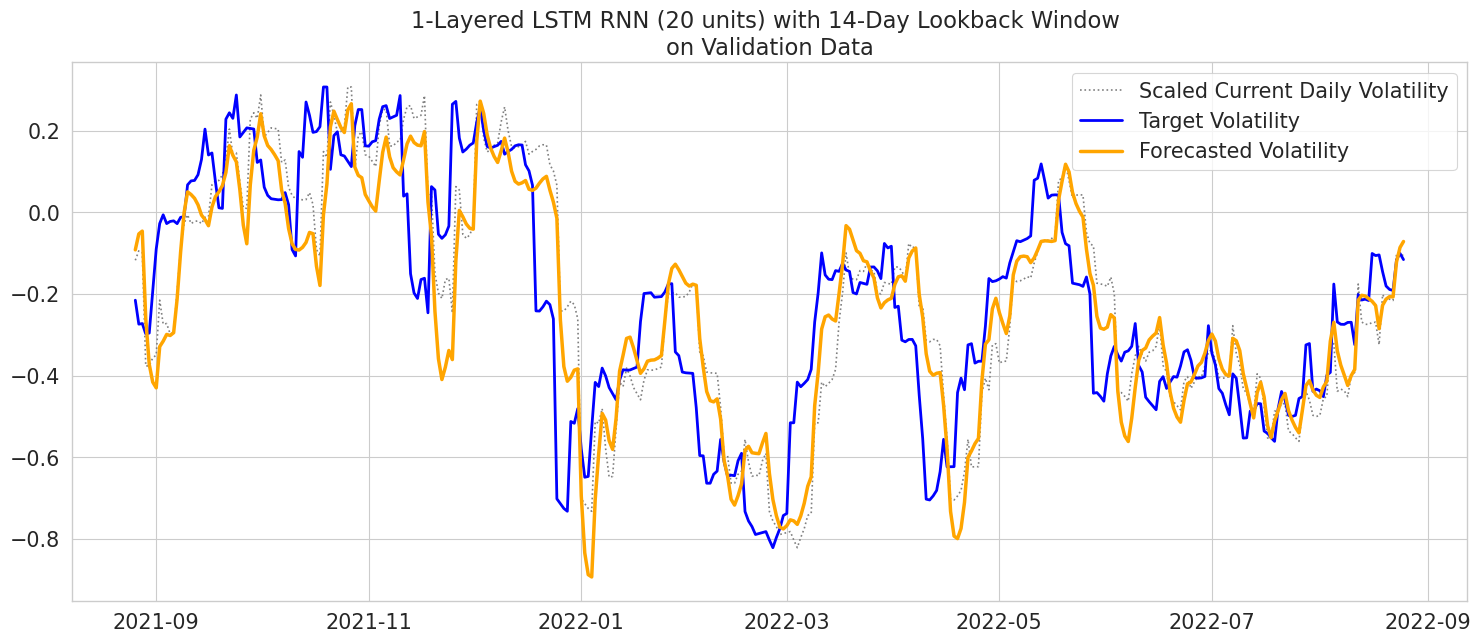

In [332]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_1.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [333]:
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"GARCH(1,1) - Normal",2.804197,0.198950,1.061152
1,"GARCH(1,1) - Student",2.560835,0.183397,0.974900
2,"GARCH(2,2) - Student",2.839917,0.194501,1.066700
3,"GARCH(1,1) - Normal",2.981327,0.183111,1.091091
4,"GARCH(1,1) - Student",2.630303,0.168665,0.980298
5,"GARCH(2,2) - Student",2.845461,0.178480,1.062523
6,"GARCH(1,1) - Normal",2.697622,0.207025,1.183090
7,"GARCH(1,1) - Student",2.099552,0.177573,0.965111
8,"Simple LR Fully Connected NN, n_past=21",3.637323,0.269018,1.449894
9,"LSTM 1 layer 20 units, n_past=14",3.215290,0.173868,1.031722


In [425]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________


In [426]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

In [428]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 1s 6ms/step


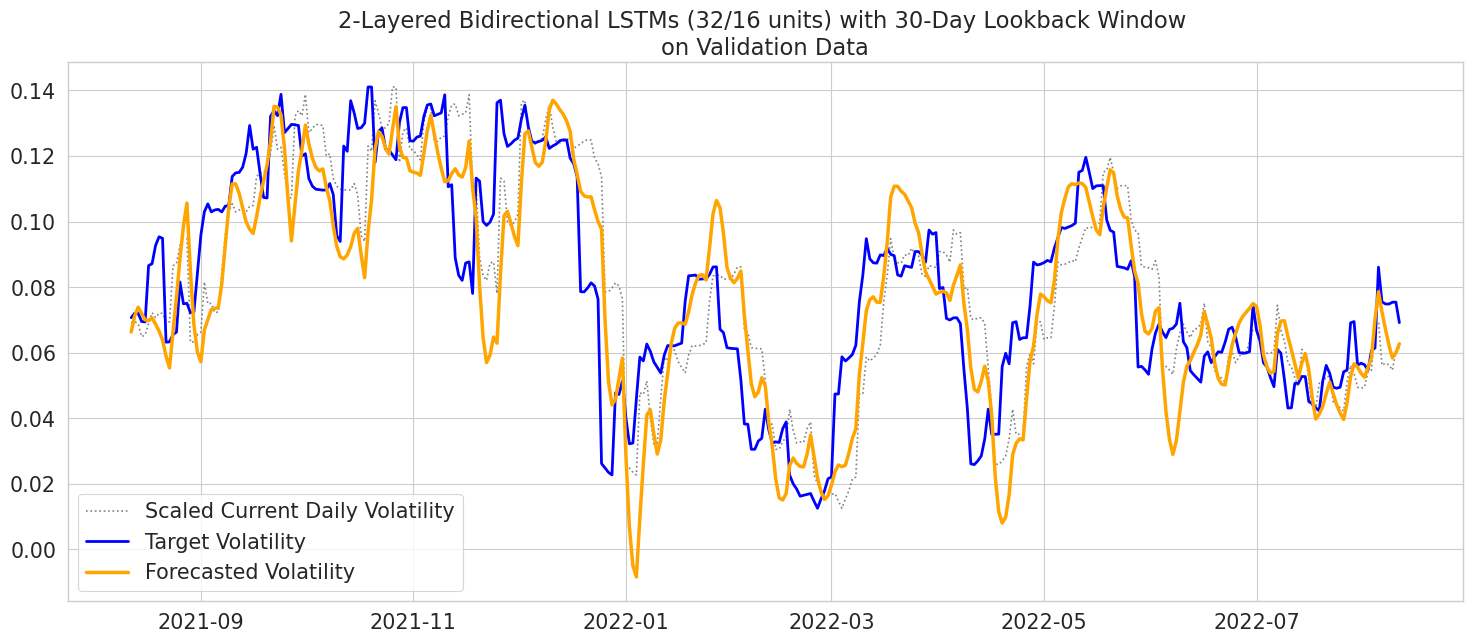

In [429]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_2.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [430]:
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"Simple LR Fully Connected NN, n_past=14",0.537150,0.025013,0.328412
1,"LSTM 1 layer 20 units, n_past=14",0.576201,0.024674,0.351400
2,2 layers Bidirect LSTM (32/16 units) | n_past=30,0.361571,0.019778,0.239482


In [431]:
tf.keras.backend.clear_session()

# INCREASING n_past TO 2 MONTHS
n_past = 60
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27,201
Trainable params: 27,201
Non-traina

In [432]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
37/37 [==============================] - 7s 43ms/step - loss: 4.6734e-05 - rmspe: 0.4352 - val_loss: 6.6060e-06 - val_rmspe: 0.3185
Epoch 2/200
37/37 [==============================] - 1s 27ms/step - loss: 3.9478e-05 - rmspe: 0.3870 - val_loss: 4.5011e-06 - val_rmspe: 0.2654
Epoch 3/200
37/37 [==============================] - 1s 27ms/step - loss: 3.6407e-05 - rmspe: 0.3543 - val_loss: 2.9966e-06 - val_rmspe: 0.2121
Epoch 4/200
37/37 [==============================] - 1s 25ms/step - loss: 3.1771e-05 - rmspe: 0.3370 - val_loss: 3.4109e-06 - val_rmspe: 0.2308
Epoch 5/200
37/37 [==============================] - 1s 28ms/step - loss: 2.6221e-05 - rmspe: 0.3070 - val_loss: 2.4990e-06 - val_rmspe: 0.1914
Epoch 6/200
37/37 [==============================] - 1s 25ms/step - loss: 2.0621e-05 - rmspe: 0.2859 - val_loss: 3.0533e-06 - val_rmspe: 0.2152
Epoch 7/200
37/37 [==============================] - 1s 24ms/step - loss: 1.8424e-05 - rmspe: 0.2797 - val_loss: 4.2882e-06 - val_rmspe:

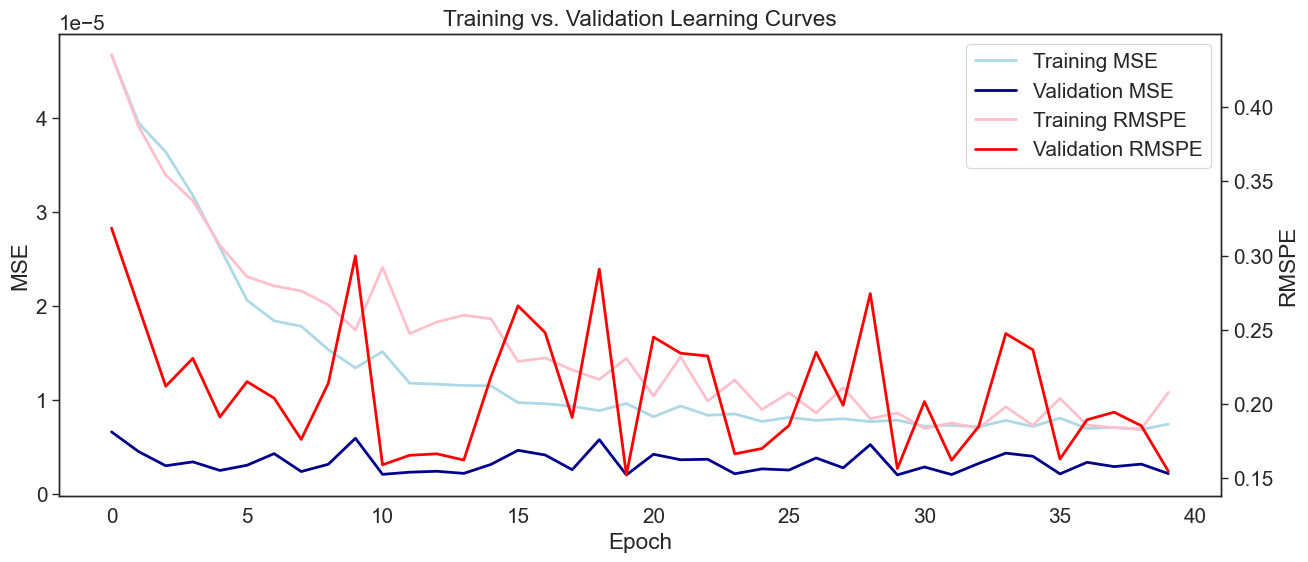

In [433]:
viz_train_val_metrics(lstm_3_res)

In [434]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 1s 5ms/step


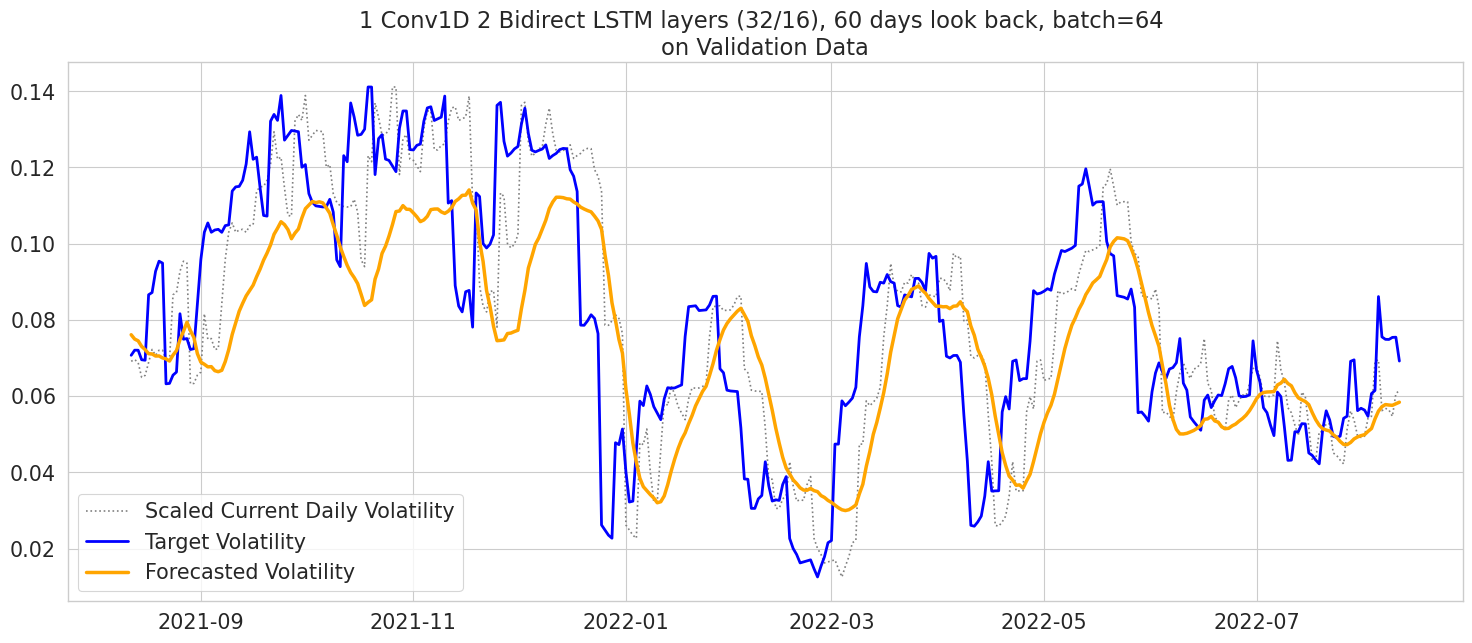

In [435]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
# plt.savefig(os.path.join(directory_to_img, 'lstm_3.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [436]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"Simple LR Fully Connected NN, n_past=14",0.537150,0.025013,0.328412
1,"LSTM 1 layer 20 units, n_past=14",0.576201,0.024674,0.351400
2,2 layers Bidirect LSTM (32/16 units) | n_past=30,0.361571,0.019778,0.239482
3,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=60, batch=64",0.521479,0.025034,0.330819
